In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
history = pd.read_csv("new_history.csv")

In [4]:
history.head(5)

,Hour,Temperature,Load
0,1,43.72,1384494.0
1,2,42.72,1392822.0
2,3,41.84,1407887.0
3,4,41.04,1438658.0
4,5,40.56,1484046.0


In [5]:
X = history[["Hour","Temperature"]]
y = history["Load"]

In [6]:
X.head()

,Hour,Temperature
0,1,43.72
1,2,42.72
2,3,41.84
3,4,41.04
4,5,40.56


In [7]:
y.head()

0    1384494.0
1    1392822.0
2    1407887.0
3    1438658.0
4    1484046.0
Name: Load, dtype: float64

In [8]:
len(history)

35064

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [11]:
scaler = StandardScaler()

In [12]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

scaled_X_train = scaled_X_train.astype('int')
scaled_X_test = scaled_X_test.astype('int')
y_train = y_train.astype('int')
y_test = y_test.astype('int')

Elbow Method for Choosing Reasonable K Values

NOTE: This uses the test set for the hyperparameter selection of K.

In [13]:

# TEST ERROR PER DEGREE
test_rmse_errors = []

for k in range(1,100):
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train) 
   
    y_pred_test = knn_model.predict(scaled_X_test)
    
    
    # Errors on Test Set
    test_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))

    # Append errors to lists for plotting later
    
    test_rmse_errors.append(test_RMSE)

Text(0.5, 0, 'K Value')

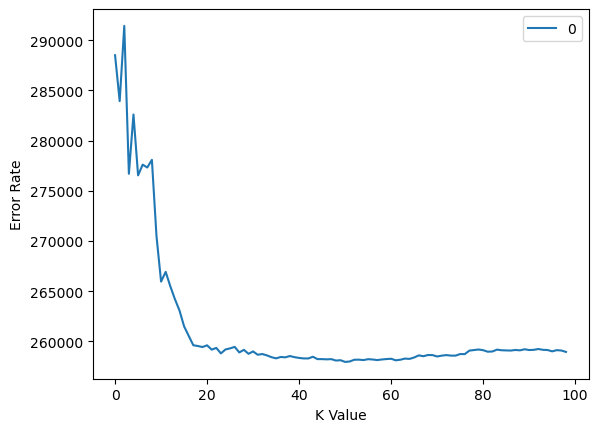

In [14]:
#plotting the rmse values against k values
curve = pd.DataFrame(test_rmse_errors) #elbow curve 
curve.plot()
plt.ylabel('Error Rate')
plt.xlabel("K Value")

In [15]:
np.where(curve[0]==min(curve[0])) # Find the lowest value for K from the plot above

(array([50], dtype=int64),)

Full Cross Validation Grid Search for K Value

Creating a Pipeline to find K value
Follow along very carefully here! We use very specific string codes AND variable names here so that everything matches up correctly. This is not a case where you can easily swap out variable names for whatever you want!

We'll use a Pipeline object to set up a workflow of operations:

Scale Data
Create Model on Scaled Data
*How does the Scaler work inside a Pipeline with CV? Is scikit-learn "smart" enough to understand .fit() on train vs .transform() on train and test?**

**Yes! Scikit-Learn's pipeline is well suited for this! Full Info in Documentation **

When you use the StandardScaler as a step inside a Pipeline then scikit-learn will internally do the job for you.

What happens can be discribed as follows:

Step 0: The data are split into TRAINING data and TEST data according to the cv parameter that you specified in the GridSearchCV.
Step 1: the scaler is fitted on the TRAINING data
Step 2: the scaler transforms TRAINING data
Step 3: the models are fitted/trained using the transformed TRAINING data
Step 4: the scaler is used to transform the TEST data
Step 5: the trained models predict using the transformed TEST data


In [16]:
knn = KNeighborsRegressor(49)

In [17]:
knn.fit(scaled_X_train,y_train)

KNeighborsRegressor(n_neighbors=49)

In [18]:
predicted_test_load = knn.predict(scaled_X_test)

In [19]:
test_RMSE_50k = np.sqrt(mean_squared_error(y_test,predicted_test_load))
test_RMSE_50k

258094.31031899774

In [20]:
actual_test_mean = y_test.mean()
actual_test_mean

1340897.9956273765

In [21]:
error_percentage = (test_RMSE_50k/actual_test_mean)*100
error_percentage

19.247870543518943

Text(0.5, 0, 'Test Data')

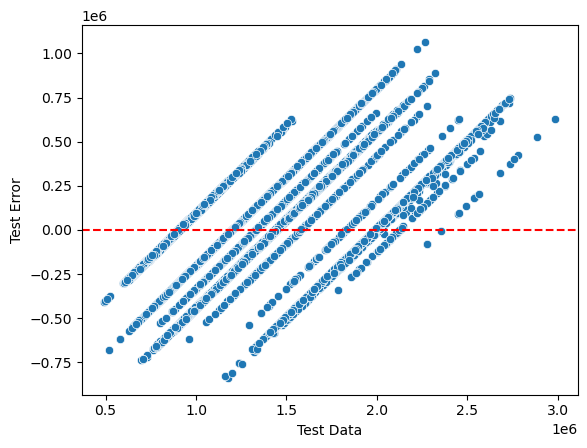

In [22]:

test_resd = y_test-predicted_test_load
sns.scatterplot(x=y_test,y=test_resd)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylabel("Test Error")
plt.xlabel("Test Data")

Text(0, 0.5, 'Predicted Test Load')

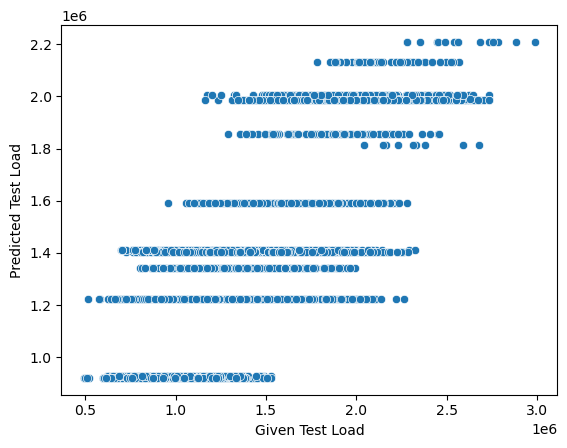

In [23]:
sns.scatterplot(x=y_test,y=y_pred_test)
plt.xlabel("Given Test Load")
plt.ylabel("Predicted Test Load")

In [24]:
Final_model = KNeighborsRegressor(50)

In [25]:
Final_model.fit(scaler.fit_transform(X),y)

KNeighborsRegressor(n_neighbors=50)

In [26]:
from joblib import dump, load

In [27]:
dump(Final_model, 'KNeighborsRegressor50.joblib') 

['KNeighborsRegressor50.joblib']

In [28]:
loaded_model = load('KNeighborsRegressor50.joblib')

In [29]:
data_to_be_predicted = pd.read_csv("data-to-be-forecast.csv")

In [30]:
data_to_be_predicted.head()

,Date,Hour,Temperature,Load
0,01-Jan-06,1,60.52,NaN
1,01-Jan-06,2,60.32,NaN
2,01-Jan-06,3,60.16,NaN
3,01-Jan-06,4,59.84,NaN
4,01-Jan-06,5,59.88,NaN


In [31]:
new_X = data_to_be_predicted[["Hour","Temperature"]]
new_X

,Hour,Temperature
0,1,60.52
1,2,60.32
2,3,60.16
3,4,59.84
4,5,59.88
...,...,...
8755,20,71.48
8756,21,70.88
8757,22,70.32
8758,23,69.84


In [32]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
predicted_Y = loaded_model.predict(scaler.fit_transform(new_X))

In [33]:
predicted_Y

array([ 796295.46,  742944.98,  728366.08, ..., 1297202.24, 1132725.98,
        977124.16])

In [34]:
data_to_be_predicted["Load"] = predicted_Y

In [35]:
data_to_be_predicted.head()

,Date,Hour,Temperature,Load
0,01-Jan-06,1,60.52,796295.46
1,01-Jan-06,2,60.32,742944.98
2,01-Jan-06,3,60.16,728366.08
3,01-Jan-06,4,59.84,723703.54
4,01-Jan-06,5,59.88,757948.48


In [36]:
data_to_be_predicted.to_csv("predicted_data_by_KNR.csv",index=False)

In [37]:
len(data_to_be_predicted)

8760